[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Arabas_et_al_2025/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Arabas_et_al_2025/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Arabas_et_al_2025/fig_2.ipynb)

Fig. 2 from [Arabas et al. 2025 (JAMES)](https://doi.org/10.1029/2024MS004770)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [1]:
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae
from PySDM_examples.Arabas_et_al_2025.curved_text import CurvedText
from PySDM_examples.Arabas_et_al_2025.commons import FREEZING_CONSTANTS, COOLING_RATES, TEMP_RANGE
import numpy as np
import pint
si = pint.UnitRegistry()
si.setup_matplotlib()

In [2]:
params = {
#     'illite': {
#         'm': FREEZING_CONSTANTS['illite']['ABIFM_M'],
#         'c': FREEZING_CONSTANTS['illite']['ABIFM_C'],
#         'color': 'olive'
#     },
    'dust': {
        'm': FREEZING_CONSTANTS['dust']['ABIFM_M'],
        'c': FREEZING_CONSTANTS['dust']['ABIFM_C'],
        'color': 'teal'
    },
}

In [3]:
svp = Formulae(saturation_vapour_pressure='FlatauWalkoCotton').saturation_vapour_pressure
T = np.linspace(*TEMP_RANGE) * si.K

def _T(TK):
    return (TK/si.K).to_base_units().magnitude

a_w_ice = svp.pvs_ice(_T(T)) / svp.pvs_water(_T(T))

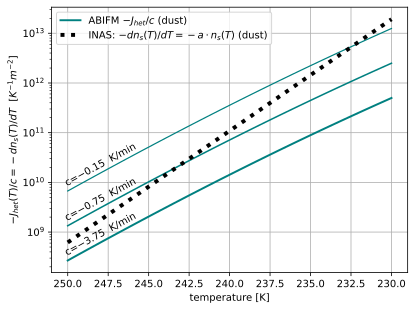

HTML(value="<a href='./fig_theory.pdf' target='_blank'>./fig_theory.pdf</a><br>")

In [7]:
cooling_rates = tuple((x*si.K/si.s).to_base_units() for x in COOLING_RATES)

for label, mc in params.items():
    formulae_abifm = Formulae(
        constants={
            'ABIFM_M': mc['m'],
            'ABIFM_C': mc['c']
        },
        heterogeneous_ice_nucleation_rate='ABIFM'
    )
    abifm_j_het = lambda T, formulae=formulae_abifm: (
        formulae.heterogeneous_ice_nucleation_rate.j_het(_T(T)) / si.m**2 / si.s
    )
    for i, c in enumerate(cooling_rates):
        c_K_min = (c / si.K * si.min).to_base_units().magnitude
        minus_J_over_c = -abifm_j_het(a_w_ice) / c
        pyplot.plot(T, minus_J_over_c,
                    color=mc['color'],
                    label='' if i!=0 else f'ABIFM $-J_{{het}}/c$ ({label})',
                    linewidth=3*abs(c.magnitude)**.15
                   )
        _ = CurvedText(T.magnitude+.666, 1.111*minus_J_over_c.magnitude,
                       text=f'c={c_K_min} K/min'.replace('-', '−'), axes=pyplot.gca(),
                       va='bottom'
                      )
        
formulae = Formulae(
    constants=FREEZING_CONSTANTS["dust"],
    freezing_temperature_spectrum='Niemand_et_al_2012'
)
inas_ns = lambda T: formulae.freezing_temperature_spectrum.ns(_T(T)) / si.m**2

a = formulae.constants.NIEMAND_A / si.K
pyplot.plot(T, -a*inas_ns(T), label=r'INAS: $-dn_{s}(T)/dT=-a \cdot n_s(T)$ (dust)',
            color='black', linestyle=':', linewidth=4)

pyplot.gca().invert_xaxis()
pyplot.yscale('log')
pyplot.grid()
pyplot.xlabel('temperature [K]')
pyplot.ylabel('$-J_{het}(T) / c = -dn_s(T)/dT$  [$K^{-1} m^{-2}$]')
pyplot.legend()
show_plot('fig_theory.pdf')